Analytic Variational Bayes
=====================

This notebook implements the example from section 3 of the FMRIB tutorial on Variational Bayes ("Inferring a single Gaussian").

We assume we have data drawn from a Gaussian distribution with true mean $\mu$ and true precision $\beta$:

$$
P(y_n | \mu, \beta) = \frac{\sqrt{\beta}}{\sqrt{2\pi}} \exp{-\frac{\beta}{2} (y_n - \mu)^2}
$$

One interpretation of this is that our data consists of repeated measurements of a fixed value ($\mu$) combined with Gaussian noise with standard deviation $\frac{1}{\sqrt{\beta}}$.

Here's how we can generate some sample data from this model in Python:

In [25]:
import numpy as np

# Ground truth parameters
# We infer the precision, BETA, but it is useful to
# derive the variance and standard deviation from it
MU_TRUTH = 42
BETA_TRUTH = 1.0
VAR_TRUTH = 1/BETA_TRUTH
STD_TRUTH = np.sqrt(VAR_TRUTH)

# Observed data samples are generated by Numpy from the ground truth
# Gaussian distribution. Reducing the number of samples should make
# the inference less 'confident' - i.e. the output variances for
# MU and BETA will increase
N = 100
DATA = np.random.normal(MU_TRUTH, STD_TRUTH, [N])
print("Data samples are:")
print(DATA)

Data samples are:
[42.78667975 40.16038847 42.33550518 41.02147398 44.44933569 42.14163057
 43.50995993 42.6556788  42.4861935  41.91065574 41.7413312  43.67407905
 41.19444219 42.30247533 41.40902706 41.19085725 41.64637968 42.31081845
 40.91181325 41.97577384 41.82185171 41.17767685 40.63642792 40.98386279
 42.32666626 42.4877075  41.16211645 42.1944423  42.24004832 40.23292838
 43.09764307 42.33308641 43.07009561 43.32425945 42.19277313 41.76368502
 40.80659711 41.72946044 40.91145583 42.38706561 42.35552626 41.71687722
 42.20576037 42.80697279 40.95702821 43.15986904 41.01919007 41.23332442
 43.06210428 41.80988785 42.47485496 42.28781011 43.55551289 42.2983658
 41.05604209 42.89571442 40.28600261 41.96550148 42.0438139  42.45416253
 43.31556442 40.55043736 42.64560469 42.38464553 44.12848225 42.63199195
 42.70539858 43.5285318  41.55605997 42.3007827  41.21668675 42.6760807
 40.4901752  43.29909006 42.6406458  41.65149276 42.42160817 41.11967912
 42.06238175 41.97506935 42.6551303

In the 'signal + noise' interpretation we can view this as noisy measurements (red crosses) of a constant signal (green line):

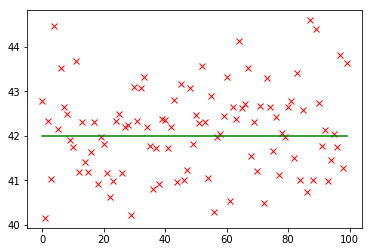

In [26]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(DATA, "rx")
plt.plot([MU_TRUTH] * N, "g")

In Variational Bayes we make the approximation that the posterior is factorised with respect to these two parameters:

$$q(\mu, \beta) = q(\mu)q(\beta)$$

Generally it is a requirement for the analytic formulation of Variational Bayes that the 'noise' and 'signal' parameters are factorised. In more complex examples where there is more than one 'signal' parameter (e.g. we are inferring the parameters of a complex nonlinear model), a combined distribution may be used for the multiple signal parameters, however the noise must still be factorised.

Another requirement for analytic VB is the choice of 'conjugate' distributions for the priors $P(\mu)$, $P(\beta)$, and the posteriors $q(\mu)$ and $q(\beta)$. This arises from Bayes's theorem which in our approximate form is:

$$q(\mu)q(\beta) \propto P(\textbf{Y} | \mu, \beta)P(\mu)P(\beta)$$

Here, $P(\textbf{Y} | \mu, \beta)$ is the likelihood and is determined from the Gaussian data model given above. It turns out that if we choose certain types of distribution for the priors $P(\mu)$ and $P(\beta)$, then $q(\mu)$ and $q(\beta)$ will end up having the same type of distribution. These 'special' distributions are known as the 'conjugate' distributions *for the likelihood*. Conjugate distributions depend on the exact form of the likelihood function.

We will not prove the conjugate distributions for this likelihood, but will simply state that for a Gaussian data model as above, the conjugate distribution for $\mu$ is Gaussian, the the conjugate distribution for $\beta$ is a Gamma distribution:

$$P(\mu) = \frac{1}{\sqrt{2\pi v_0}} \exp{-\frac{1}{2v_0}(\mu - m_0)^2}$$
$$q(\mu) = \frac{1}{\sqrt{2\pi v}} \exp{-\frac{1}{2v}(\mu - m)^2}$$

Here $m$ and $v$ are the 'hyperparameters' of the posterior for $\mu$ - they determine the inferred posterior distribution of 
$\mu$, and through the VB formulation we will infer values for them from the data. $m_0$ and $v_0$ similarly describe our prior knowledge of the likely value of $\mu$ and might incorporate existing knowledge. Alternatively by choosing a large value of $v_0$ we can have a 'non-informative' prior which would be used if we have no real idea before seeing the data what the value of $\mu$ might be.

Similarly for $\beta$ we have:

$$P(\beta) = \frac{1}{\Gamma(c_0)}\frac{\beta^{c_0-1}}{b_0^{c_0}}\exp{-\frac{\beta}{b_0}}$$
$$q(\beta) = \frac{1}{\Gamma(c)}\frac{\beta^{c-1}}{b^c}\exp{-\frac{\beta}{b}}$$

Here $b$ and $c$ are the inferred hyperparameters and $b_0$ and $c_0$ are the prior scale and shape parameters for the Gamma distribution. The mean of the Gamma distribution is given by $cb$ and the variance by $cb^2$. 

Sometimes it may be more intuitive to think of the Gamma prior in terms of a mean and variance in which case we can derive the prior hyperparameters as:

$$b_0 = \frac{\textrm{Prior variance}}{\textrm{Prior mean}}$$
$$c_0 = \frac{\textrm{Prior mean}^2}{\textrm{Prior variance}}$$

Here we'll define some non-informative priors for $\mu$ and $\beta$. Note that for the noise prior, $\beta$ we define the prior mean and variance and derive the prior hyperparameters $b_0$ and $c_0$ from this:

In [27]:
m0 = 0
v0 = 1000
beta_mean0 = 1
beta_var0 = 1000
b0 = beta_var0 / beta_mean0
c0 = beta_mean0**2 / beta_var0
print("Priors: P(mu) = N(%f, %f), P(beta) = Ga(%f, %f)" % (m0, v0, b0, c0))

Priors: P(mu) = N(0.000000, 1000.000000), P(beta) = Ga(1000.000000, 0.001000)


Next we need the update equations. These will take existing values of $m$, $v$, $b$ and $c$ and produce new estimates. By repeatedly iterating we will converge on the optimal posterior hyperparameters.

The update equations are derived by applying the Calculus of Variations to the problem of maximising the free energy - see the tutorial sections 2.2, 3.1 and 3.2 for the derivation.

Here we implement the update equations as a Python function which takes values of $m$, $v$, $b$ and $c$ and returns updated values.

In [28]:
# Equation 3.15 - these depend only on the data
S1 = np.sum(DATA)
S2 = np.sum(np.square(DATA))

def update(m, v, b, c):
    # Equation 3.17
    m = (m0 + v0 * b * c * S1) / (1 + N * v0 * b * c)

    # Equation 3.18
    v = v0 / (1 + N * v0 * b * c)

    # Equation 3.20
    X = S2 - 2*S1*m + N * (m**2 + v)

    # Equation 3.21
    b = 1 / (1 / b0 + X / 2)
    
    # Equation 3.22
    c = N / 2 + c0
    
    return m, v, b, c


The iterative process needs some starting values which we define similarly to the priors. We could in fact start off with the prior values. If the iterative process is working the starting values should not matter, however in more complex problems it is important to start out with reasonable values of the parameters or the iteration can become stuck in a local maximum and not find the best solution.

In [29]:
m = 0
v = 10
beta_mean1 = 1.0
beta_var1 = 10
b = beta_var1 / beta_mean1
c = beta_mean1**2 / beta_var1
print("Initial values: (m, v, b, c) = (%f, %f, %f, %f)" % (m, v, b, c))

Initial values: (m, v, b, c) = (0.000000, 10.000000, 10.000000, 0.100000)


Note that our initial values are not particularly close to the true values, so we are not cheating!

Finally, let's iterate 10 times and see what happens to the hyperparameters:

In [30]:
for vb_iter in range(10):
    m, v, b, c = update(m, v, b, c)
    print("Iteration %i: (m, v, b, c) = (%f, %f, %f, %f)" % (vb_iter+1, m, v, b, c))

print("Inferred mean/precision of Gaussian: %f, %f" % (m, c * b))
print("Inferred variance on Gaussian mean/precision: %f, %f" % (v, c * b**2))

Iteration 1: (m, v, b, c) = (42.118478, 0.010000, 0.020954, 50.001000)
Iteration 2: (m, v, b, c) = (42.118497, 0.009545, 0.020964, 50.001000)
Iteration 3: (m, v, b, c) = (42.118497, 0.009540, 0.020964, 50.001000)
Iteration 4: (m, v, b, c) = (42.118497, 0.009540, 0.020964, 50.001000)
Iteration 5: (m, v, b, c) = (42.118497, 0.009540, 0.020964, 50.001000)
Iteration 6: (m, v, b, c) = (42.118497, 0.009540, 0.020964, 50.001000)
Iteration 7: (m, v, b, c) = (42.118497, 0.009540, 0.020964, 50.001000)
Iteration 8: (m, v, b, c) = (42.118497, 0.009540, 0.020964, 50.001000)
Iteration 9: (m, v, b, c) = (42.118497, 0.009540, 0.020964, 50.001000)
Iteration 10: (m, v, b, c) = (42.118497, 0.009540, 0.020964, 50.001000)
Inferred mean/precision of Gaussian: 42.118497, 1.048201
Inferred variance on Gaussian mean/precision: 0.009540, 0.021974


The update equations in this case converge within just a couple of iterations and lead to inferred hyperparameters close to our ground truth. Note also that we have inferred the variance on these parameters - this gives an indication of how confident we can be in their values. If you try reducing the number of samples in the data set the variance will increase since we have less information to infer $\mu$ and $\beta$.

We can plot the inferred value of $\mu$ with error bars derived from the inferred variance:
 

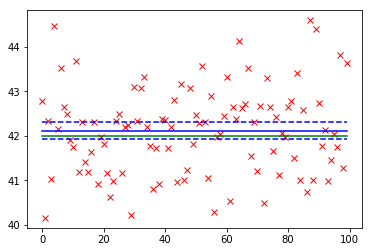

In [31]:
plt.figure()
plt.plot(DATA, "rx")
plt.plot([MU_TRUTH] * N, "g")
plt.plot([m] * N, "b")
plt.plot([m+2*np.sqrt(v)] * N, "b--")
plt.plot([m-2*np.sqrt(v)] * N, "b--")


Other things to try would include:

 - Reducing the variance of the priors, i.e. make them informative. This will cause the inferred values to move closer to the
   prior values because we are now claiming we have prior knowledge of what $\mu$ and $\beta$ must be, and this can to some
   extent override the information in the data.
   
 - Changing the initial values of $m$, $v$, $b$ and $c$ to verify that the iteration can still converge to the correct    
   solution.
 
 - Try modifying the ground truth values and verify that we still infer the correct solution.
 
 - Increasing the level of noise should cause the variance estimates in the parameters to go up
 - Reducing the number of data samples should also increase the variance estimates to go up since we have less information to go on.
 